# Contents
Welcome to our exploratory data analysis for satellite altimetry lake water data. In this notebook, we sketch out our thinking (in roughly chronological order) of how we extracted, transformed, processed, and cleaned the data. The results from this exploratory data analysis will be used when we implement our own [Kalman filter](https://github.com/pvasudev16/ml-freshwater-management/blob/main/lake_water_level_kalman_filtering.ipynb)

Our exploration includes the following topics:
- [Data loading](#data_loading) - Read in the Sentinel A data, and isolate data for Lake Winnipeg
- [Plot ground track](#ground_track) - Plot the traces across Lake Winnipeg that the Sentinel A satellite makes
- [Outlier and error exploration](#outlier_exploration) - Explore how treat errors and outliers in our measurements.
    - [Distribution of water levels](#water_level_distn) - Examine the distribution of the water levels in terms of simple Gaussian statistics.
    - [Water levels in different times of year](#seasons) - Examine how water levels may change in terms of seasons. In the literature (e.g. [DAHITI](https://hess.copernicus.org/preprints/12/4813/2015/hess-2015-86-manuscript-version3.pdf)), data from winter months is excluded. In our implementation, we kept data from winter months.
    - [Absolute Deviance from the Mean (ADM)](#adm) - Define errors based on how far they are from the median.
    - [Outlier rejection](#outlier_rejection) - Reject data points that lie $\pm 2 \sigma$ from the mean.
- [Other ideas](#other_ideas): Explore some other ideas for treating the data. We considered using a state variable regression (SVR) for outlier regression, and see how we deduced that each day corresponded to a different track over Lake Winnipeg.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import matplotlib
import cartopy.crs as ccrs # Projections
import cartopy.feature as cfeature
import cartopy
import datetime

<a id='data_loading'></a>
## Data loading

In [2]:
sentinel_data_A = pd.read_csv("data/Sentinel_3A_water_level_Version0.csv")
sentinel_data_A = sentinel_data_A.rename(
    columns={
        "Date (YYYYMMDD)" : "date",
        "Lake_name" : "lake_name",
        "Latitude" : "latitude",
        "Longitude" : "longitude",
        "Relaive_orbit" : "relative_orbit",
        "Lake water level (m)" : "lake_water_level"
    }
)

###### Isolate Lake Winnipeg data

In [3]:
lake_winnipeg = sentinel_data_A[
    sentinel_data_A["lake_name"] == "Winnipeg"
]

In [4]:
pd.unique(lake_winnipeg[
    lake_winnipeg["relative_orbit"] == pd.unique(lake_winnipeg["relative_orbit"])[0]
]["date"])

array([20160401, 20160428, 20160525, 20160621, 20160718, 20160814,
       20160910, 20161007, 20161103, 20161130, 20161227, 20170123,
       20170219, 20170318, 20170414, 20170511, 20170607, 20170704,
       20170731, 20170827, 20170923, 20171020, 20171116, 20171213,
       20180109, 20180205, 20180304, 20180331, 20180427, 20180620,
       20180717, 20180813, 20180909, 20181006, 20181102, 20181129,
       20181226, 20190122, 20190218, 20190317, 20190510, 20190606,
       20190703, 20190730, 20190826, 20210604, 20210701, 20210728,
       20210824, 20210920])

<a id="ground_track"></a>
## Plot ground track along Lake Winnipeg

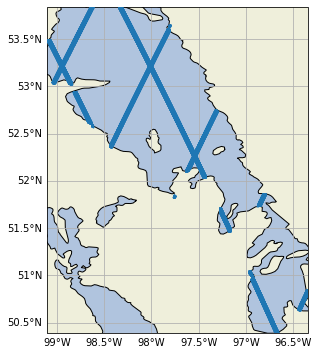

In [5]:
# Get the extent from the data
extent = [
    lake_winnipeg["longitude"].min(),
    lake_winnipeg["longitude"].max(),
    lake_winnipeg["latitude"].min(),
    lake_winnipeg["latitude"].max(),
]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# High resolution lakes
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')

# Land, river, and lakes
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(lakes_50m, facecolor='lightsteelblue',edgecolor='black')

# Plot altimetry points
ax.scatter(
    x=np.array(lake_winnipeg["longitude"]),
    y=np.array(lake_winnipeg["latitude"]),
    zorder=10,
    s=1
)

# Format gridlines
# https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

<a id="outlier_exploration"></a>
## Explore Errors and Outliers
In this section, we take a look at how we can estimate error on the measurements (an important part of Kalman filtering) and how we can think about rejecting outliers.

<a id="water_level_distn"></a>
### Distribution of Water Levels... ignore $\mu\pm2\sigma$?
We sketch our idea for outlier rejection below. Our idea is essentially to drop any points that lie more than two standard deviations away from the mean.

In [6]:
lake_water_mean = lake_winnipeg["lake_water_level"].mean()
lake_water_std = lake_winnipeg["lake_water_level"].std()
print(f"The mean lakewater level is {lake_water_mean:0.2f}m and the standard deviation is {lake_water_std:0.2f}m")

The mean lakewater level is 217.27m and the standard deviation is 1.16m


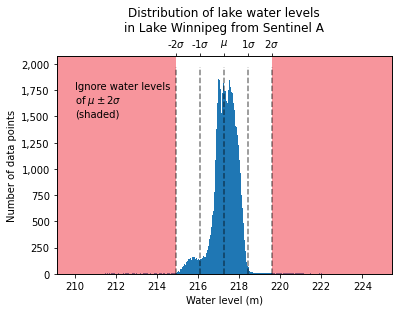

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(
    x=lake_winnipeg["lake_water_level"],
    bins=np.linspace(
        lake_water_mean - 5 * lake_water_std,
        lake_water_mean + 5 * lake_water_std,
        500
    )
)
ax.set_xlim(
    [
        lake_water_mean - 7 * lake_water_std,
        lake_water_mean + 7 * lake_water_std,
    ]
)

ax.axvspan(
    xmin=ax.get_xlim()[0],
    xmax=lake_water_mean - 2 * lake_water_std,
    facecolor="#F02D3A",
    alpha=0.5
)
ax.axvspan(
    xmin=lake_water_mean + 2 * lake_water_std,
    xmax=ax.get_xlim()[1],
    facecolor="#F02D3A",
    alpha=0.5
)


vline_water_levels = [lake_water_mean + i * lake_water_std for i in range(-2,3)]
ax.vlines(
    x=vline_water_levels,
    ymin=ax.get_ylim()[0],
    ymax=ax.get_ylim()[1],
    color='k',
    linestyle='--',
    alpha=0.5
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_xlabel("Water level (m)")
ax.set_ylabel("Number of data points")

ax1 = ax.twiny()
ax1.set_xlim(
    ax.get_xlim()
)
ax1.set_xticks(
    [lake_water_mean + i * lake_water_std for i in range(-2, 3)]
)
ax1.set_xticklabels(
    [
        r'-2$\sigma$',
        r'-1$\sigma$',
        r'$\mu$',
        r'1$\sigma$',
        r'2$\sigma$',
    ]
)

ax.text(210, 1500, 'Ignore water levels\n' + r'of $\mu  \pm2\sigma$' + '\n(shaded)')
plt.title("Distribution of lake water levels\nin Lake Winnipeg from Sentinel A")
plt.show()

**Analysis**: We remark a small peak in the data at water levels of about 215.5m. This peak is the data due to winter months. This data could be rejected, but was not (see [how we rejected data](#outlier_rejection)).

<a id="seasons"></a>
### Water levels in different times of year
There is ice cover in winter. Take summary stats of winter and non-winter and see how different they are.
I'm not sure this is particularly informative.

In [8]:
lake_winnipeg.head()

,date,lake_name,latitude,longitude,relative_orbit,lake_water_level
228868,20160401,Winnipeg,51.860057,-96.819518,283,217.4011
228869,20160401,Winnipeg,51.857120,-96.820913,283,217.5197
228870,20160401,Winnipeg,51.854183,-96.822309,283,217.2064
228871,20160401,Winnipeg,51.851245,-96.823704,283,217.3213
228872,20160401,Winnipeg,51.848308,-96.825099,283,217.3166


In [9]:
def add_winter_column(lake_winnipeg):
    # Add a column to indicate if the date is in winter or not.
    lake_winnipeg.loc[:, "date_as_datetime"] = pd.to_datetime(lake_winnipeg.loc[:, "date"], format="%Y%m%d")
    lake_winnipeg.loc[:, "month"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.month)
    lake_winnipeg.loc[:, "day"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.day)
    lake_winnipeg.loc[:, "winter"] = ((lake_winnipeg["month"] < 4) | (lake_winnipeg["month"] > 10))
    return lake_winnipeg

def remove_winter_column(lake_winnipeg):
    lake_winnipeg = lake_winnipeg.drop(columns=["winter", "month", "day", "date_as_datetime"])
    return lake_winnipeg

In [10]:
lake_winnipeg = add_winter_column(lake_winnipeg)

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93954/2287572897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[:, "date_as_datetime"] = pd.to_datetime(lake_winnipeg.loc[:, "date"], format="%Y%m%d")
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93954/2287572897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[:, "month"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.month)
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_

The mean lake water level in winter (Nov - March) is 216.97m.
The mean lake water level in non-winter (Apr - Oct) is 217.41m.

In [11]:
lake_winnipeg.loc[
    lake_winnipeg["winter"] == True,
    "lake_water_level"
].describe()

count    35584.000000
mean       216.977128
std          1.037623
min        187.942875
25%        216.655480
50%        217.051439
75%        217.488527
max        227.617834
Name: lake_water_level, dtype: float64

In [12]:
lake_winnipeg.loc[
    lake_winnipeg["winter"] == False,
    "lake_water_level"
].describe()

count    72920.000000
mean       217.409069
std          1.196905
min        183.408658
25%        217.159186
50%        217.483098
75%        217.780306
max        235.595841
Name: lake_water_level, dtype: float64

In [13]:
#lake_winnipeg = remove_winter_column(lake_winnipeg)

<a id="adm"></a>
### Calculate Absolute Deviation from the Mean (ADM)
Take the median along each track, and then subtract it from all the measurements. Most measurements have an error well below 0.25 m. See the DAHITI paper for more details.

Every day in the data represents a different track. (See the bottom of this workbook for a map that shows different tracks on different days.)

**Analysis**: We see an issue with ADM, which is that the data point that *is* the median will have zero error by definition. As such, we assume there is a 0.25m error in all the measurements on top of the ADM. This assumption came from group discussion, where we said satellite measurements may have a precision of 0.25m.

##### ADM = "Absolute deviation around the median"
###### (see https://hess.copernicus.org/articles/19/4345/2015/hess-19-4345-2015.pdf)

In [14]:
def add_adm_error(lake_winnipeg):
    lake_winnipeg["error"] = 0
    unique_dates = pd.unique(lake_winnipeg["date"])
    for date in unique_dates:
        median_water_level = lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].median()
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "error"
        ] = lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].apply(lambda x: np.abs(x - median_water_level) + 0.25)
    return lake_winnipeg

def remove_adm_error(lake_winnipeg):
    lake_winnipeg = lake_winnipeg.drop(columns=["error"])
    return lake_winnipeg

In [15]:
lake_winnipeg = add_adm_error(lake_winnipeg)

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93954/1372700968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg["error"] = 0
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93954/1372700968.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[


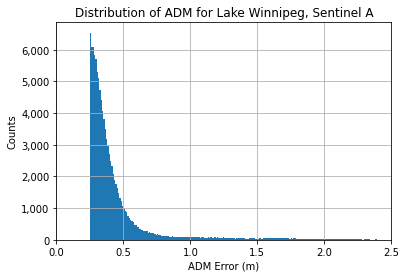

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(
    lake_winnipeg["error"],
    bins=np.linspace(0, 5, 501)
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_xlabel("ADM Error (m)")
ax.set_ylabel("Counts")
ax.grid(True)
ax.set_xlim([0, 2.5])
plt.title("Distribution of ADM for Lake Winnipeg, Sentinel A")
plt.show()

<a id="outlier_rejection"></a>
### Outliers: Reject $\pm2\sigma$
For each track, take the mean and reject points that are more than $\mu\pm2\sigma$ from the mean.

In practice, we do not actually remove this data from the data frame; we make a column called "reject" and label the points we wish to reject as "True"

In [17]:
lake_winnipeg["mean_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("mean")
lake_winnipeg["std_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("std")
number_of_standard_deviations = 2 # Reject points that are more than number_of_standard_deviation*std from the mean

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93954/3229246027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg["mean_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("mean")
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93954/3229246027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg["std_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("std")


In [18]:
lake_winnipeg["reject"] = lake_winnipeg.apply(
    lambda row: True if np.abs(
        row["lake_water_level"] - row["mean_track_lake_water_level"]
    ) > number_of_standard_deviations*row["std_track_lake_water_level"] else False,
    axis=1
)

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93954/3296338023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg["reject"] = lake_winnipeg.apply(


In [19]:
lake_winnipeg.loc[
    lake_winnipeg["reject"] == False
].head()

,date,lake_name,latitude,longitude,relative_orbit,lake_water_level,date_as_datetime,month,day,winter,error,mean_track_lake_water_level,std_track_lake_water_level,reject
228868,20160401,Winnipeg,51.860057,-96.819518,283,217.4011,2016-04-01,4,1,False,0.29045,217.365902,0.078854,False
228869,20160401,Winnipeg,51.857120,-96.820913,283,217.5197,2016-04-01,4,1,False,0.40905,217.365902,0.078854,False
228871,20160401,Winnipeg,51.851245,-96.823704,283,217.3213,2016-04-01,4,1,False,0.28935,217.365902,0.078854,False
228872,20160401,Winnipeg,51.848308,-96.825099,283,217.3166,2016-04-01,4,1,False,0.29405,217.365902,0.078854,False
228873,20160401,Winnipeg,51.845371,-96.826494,283,217.3736,2016-04-01,4,1,False,0.26295,217.365902,0.078854,False


In [20]:
# Write the processed data frame to file, for the purposes of reusing for Kalman filtering and making figures
lake_winnipeg.to_csv("./processed/sentinel_a_lake_winnipeg_remove_outliers.csv", index=False)

<a id="other_ideas"></a>
# Other ideas
### Outliers: Apply Linear SV regression (did not end up panning out)
Along a track of data, apply a linear (flat) SV regression. This gives "wide margin" regression. DAHITI suggests to ignore points that sit outside the margins of +/- 5cm. Perhaps we can be more generous to 15 cm?

Plot the water levels against the longitude coordinate. It seems we can get away with this, since none of our tracks are vertical (i.e. at const longitude)

In [21]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression

In [22]:
lake_winnipeg = lake_winnipeg.loc[
    lake_winnipeg["reject"] == False
]

In [23]:
# Illustrate for one date
date = pd.unique(lake_winnipeg["date"])[5]
X = np.array(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ]
).reshape(-1, 1)
y = np.array(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "lake_water_level"
    ]
).ravel()
svm_reg = LinearSVR(epsilon=0.15, max_iter=1000, C=1e6)
svm_reg.fit(X, y)

/Users/pvasudev/.virtualenvs/ml-freshwater/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(C=1000000.0, epsilon=0.15)

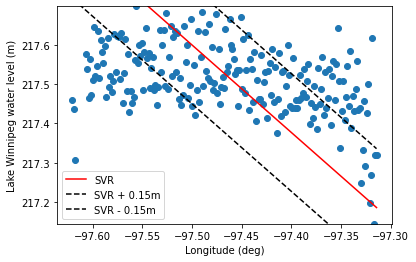

In [24]:
fig = plt.figure()

# Set x-range (i.e. longitude range)
longitude_range = np.linspace(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ].min(),
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ].max(),
    100
)

water_levels_predicted = svm_reg.predict(longitude_range.reshape(100, 1))

ax = fig.add_subplot(111)
ax.plot(longitude_range, water_levels_predicted, label="SVR", color="r")
ax.plot(longitude_range, water_levels_predicted - svm_reg.epsilon, "k--", label = "SVR + 0.15m")
ax.plot(longitude_range, water_levels_predicted + svm_reg.epsilon, "k--", label = "SVR - 0.15m")
ax.scatter(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ],
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "lake_water_level"
    ]
)
ax.set_ylim(
    [
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].min(),
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].max(),
    ]
)
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Lake Winnipeg water level (m)")
ax.legend()
plt.show()

**Analysis**: This doesn't work as well as shown in the DAHITI papers because (i) we have already rejected the outliers that sit far from the median (reject +/- 2*sigma), and (ii) we can't constrain the slope to be zero, as they suggest.

Moreover, the "wide margin regression" seems to suggest rejecting some meaningful data. Therefore, we did not pursue this idea.

### Every day is a different track

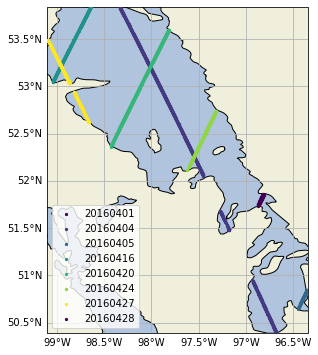

In [25]:
# Change this parameter
number_of_tracks = 8

# Make the cartopy map the background
extent = [
    lake_winnipeg["longitude"].min(),
    lake_winnipeg["longitude"].max(),
    lake_winnipeg["latitude"].min(),
    lake_winnipeg["latitude"].max(),
]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(lakes_50m, facecolor='lightsteelblue',edgecolor='black')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Plot altimetry points
number_of_colours = 7
cmap = matplotlib.cm.get_cmap('viridis')
colours = cmap(np.linspace(0, 1, number_of_colours))
for i, date in enumerate(pd.unique(lake_winnipeg["date"])[0:number_of_tracks]):
    ax.scatter(
        x=lake_winnipeg.loc[
            lake_winnipeg["date_as_datetime"] == pd.to_datetime(date, format="%Y%m%d"),
            "longitude"
        ],
        y=lake_winnipeg.loc[
            lake_winnipeg["date_as_datetime"] == pd.to_datetime(date, format="%Y%m%d"),
            "latitude"
        ],
        s=5,
        color=colours[i%number_of_colours],
        label=date,
        zorder=10
    )
ax.legend()
plt.show()